# 04 - Applied ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
import networkx as nx
%matplotlib inline

//anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Question 1
## 1. A naive analysis

First, we load our data and have a look at its contents.

In [2]:
data = pd.read_csv('lalonde.csv')
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Now, we will try to compare the distribution of the feature `re78` (i.e. the real earnings in 1978) between the two groups. To do so, we first use the `DataFrame.describe` function on both groups.

In [3]:
# Separate treated and untreated people
data_treated = data[data["treat"] == 1]
data_untreated = data[data["treat"] == 0]

data_treated[['re78']].describe()

,re78
count,185.000000
mean,6349.143530
std,7867.402218
min,0.000000
25%,485.229800
50%,4232.309000
75%,9642.999000
max,60307.930000


In [4]:
data_treated[['re78']].describe()

,re78
count,185.000000
mean,6349.143530
std,7867.402218
min,0.000000
25%,485.229800
50%,4232.309000
75%,9642.999000
max,60307.930000


In order to get more insight a visualize these numbers better, we create a helper function that plots the histogram and boxplot for both groups. This function is very useful as it will be reused several times later on.

In [5]:
def plot_feature_hist(feature_name, data):
    """Display, for the given feature, two histograms on top of each other representing 
       the distribution of respectively the treated and untreated groups, as well as a 
       boxplot of both groups.
    
    feature_name: name of the feature to be plotted
    data: data on which the plots should be based
    """
    
    # Compute the minimum and maximum value to set the scale of the histogram
    r_min = data[feature_name].min()
    r_max = data[feature_name].max()
    
    # Separate treated and untreated people
    data_treated = data[data["treat"] == 1]
    data_untreated = data[data["treat"] == 0]
    
    # Create plots
    plt.figure(figsize=(14,5))
    plt.suptitle(feature_name, fontsize=18)
    #plt.subplot(1,2,1)
    ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    
    # Plot two histograms for treated and untreated groups
    ax1.hist(data_treated[feature_name], normed=True, bins=30, range=(r_min, r_max), color='blue', alpha=0.7)
    ax1.hist(data_untreated[feature_name], normed=True, bins=30, range=(r_min, r_max), color='orange', alpha=0.7)
    
    # Add legend and display the plot
    ax1.legend(['Treated subjects', 'Untreated subjects'], loc='upper right', prop={'size': 12})
    
    # Plot a boxplot for both groups next to the histogram
    ax2 = plt.subplot2grid((1, 3), (0, 2))
    box = ax2.boxplot([data_treated[feature_name], data_untreated[feature_name]], patch_artist=True, sym='k.')
    
    # Set edge color
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(box[element], color='black')
    plt.setp(box['medians'], color='white')
    
    # Set fill color of the boxplots
    for patch, color in zip(box['boxes'], ['blue', 'orange']):
        patch.set_facecolor(color)
    
    # Rename the ticks of the x axis
    plt.xticks([1, 2], ['Treated subjects', 'Untreated subjects'])
    
    plt.show()

Now let's use this function to display the distribution of `re78`.

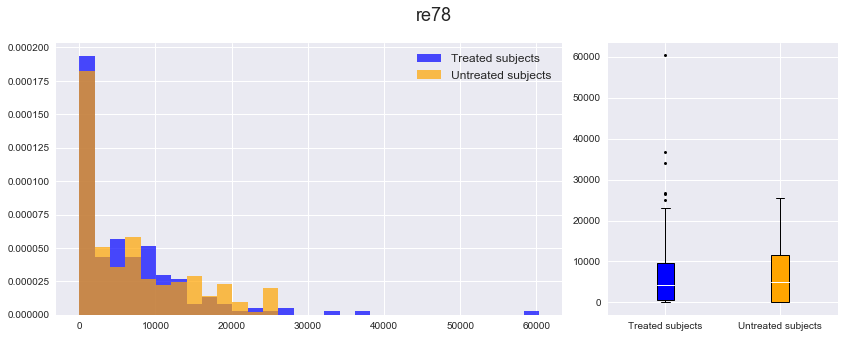

In [6]:
plot_feature_hist('re78', data)

When we look at the data only using this naive approach, we can be tempted to say that this treatment has no effect. Indeed, from this superficial analysis, the distribution of `re78` seems very similar for both groups, thus the logical conclusion for a naive researcher would be to say that the treatment had no effect.

## 2. A closer look at the data

Now, we will compare the distribution of each feature between the two groups and thus determine how well the treated group matches with the control group. As our dataset contains both continuous and binary features, we will deal with them separately, as different types of visualization arre needed to describe them.

### Analyzing continuous features
First, we will compare the difference in distibution of the continuous features. For this, we can conveniently reuse the function defined in the first part.

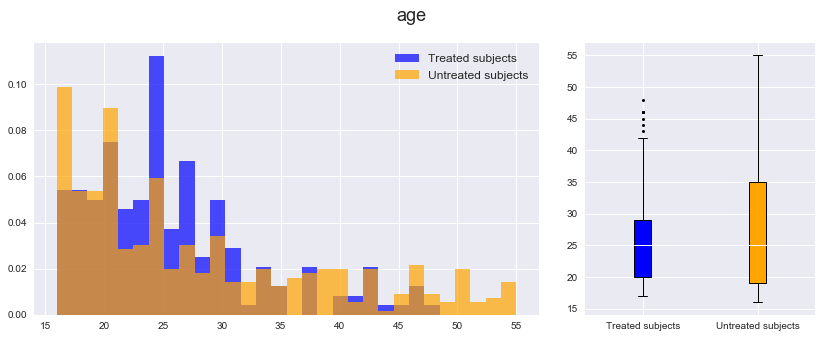

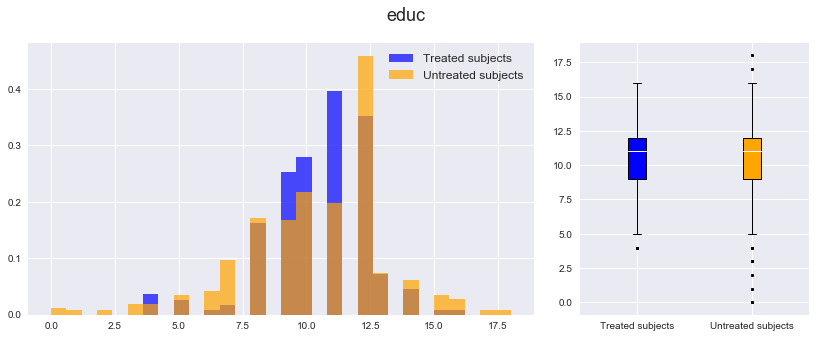

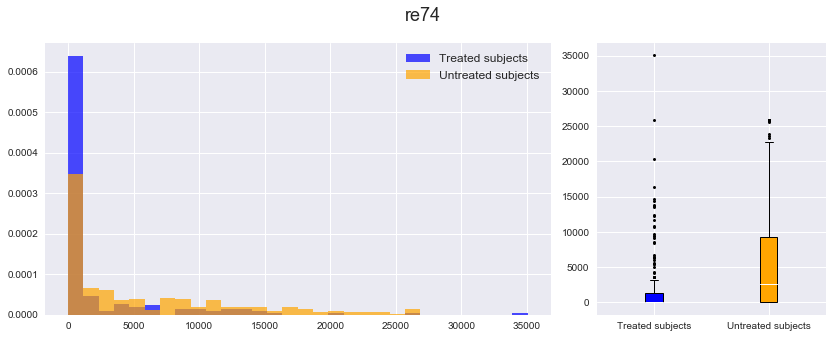

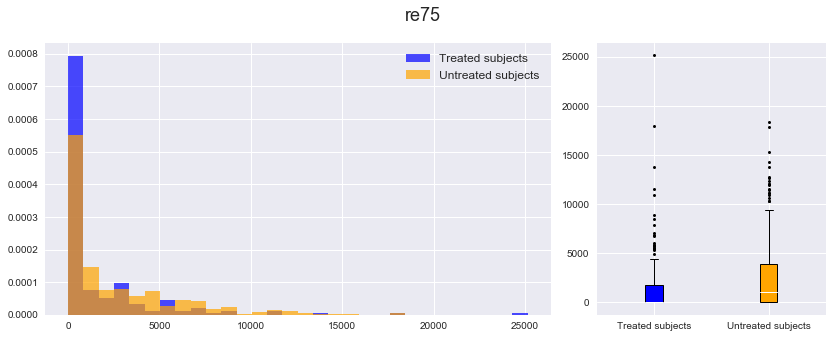

In [7]:
# Display histogram plots for continuous features
cts_features = ["age", "educ", "re74", "re75"]
for col in cts_features:
    plot_feature_hist(col, data)

We can observe from the plots above that the distribution is not very similar for most features. People from the control group seem to be a bit older than the treated group. Moreover, both the revenues in 1974 and 1975 seem to be higher for the control group. But on the contrary, the education seem to be quite similar between the two groups

### Analyzing binary features

In [8]:
data['white'] = ((1-data['black']) & (1-data['hispan']))
data.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,1


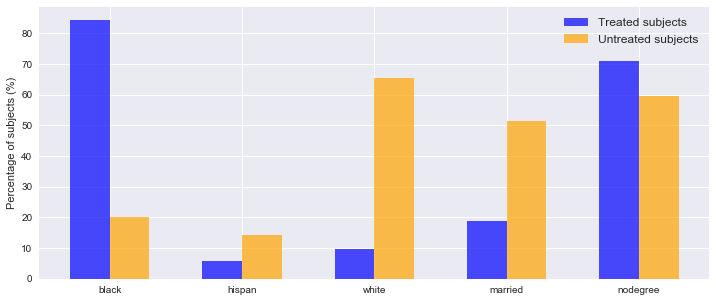

In [13]:
def plot_binary_features(data):
    binary_features = ['black', 'hispan', 'white', 'married', 'nodegree']

    # Separate treated and untreated people
    data_treated = data[data["treat"] == 1]
    data_untreated = data[data["treat"] == 0]

    # Get total number of subjects in both groups
    nb_subjects_treated = data_treated.shape[0]
    nb_subjects_untreated = data_untreated.shape[0]

    # Compute the percentage of each binary feature in both groups
    percentage_treated = [(100*data_treated[name].value_counts()[1] / nb_subjects_treated) for name in binary_features]
    percentage_untreated = [(100*data_untreated[name].value_counts()[1] / nb_subjects_untreated) for name in binary_features]

    # Create bar plots
    fig, ax = plt.subplots(figsize=(12,5))

    # Parameters for the width and position of the bars
    width = 0.3
    left = [i for i in range(len(percentage_treated))]

    # Plot bars for treated subjects
    plt.bar(left, percentage_treated, width=width, alpha=0.7, color='blue')
    # Plot bars for untreated subjects
    plt.bar([l + width for l in left], percentage_untreated, width=width, alpha=0.7, color='orange')

    ax.set_ylabel('Percentage of subjects (%)')

    # Set the labels and position of the ticks on the x-axis
    ax.set_xticklabels(binary_features)
    ax.set_xticks([p + width/2 for p in left])

    # Add legend and display the plot
    plt.legend(['Treated subjects', 'Untreated subjects'], loc='upper right', prop={'size': 12})
    plt.show()
    
plot_binary_features(data)

We can observe that the distribution of these features are quite different between the two groups. The biggest difference is the proportion of black and white people, with the treated group having proportionally about 4 times more black people, while the control group has about 5.5 times more white people. There is also a larger proportion of married people, as well as hispanic people in the control group. Finally, there is marginally a large percentage of people without a degree in the treated group.

### Conclusions
What we observe with the plots above is that the population of the treatement group and the population of the control group are very different. Therefore, a superficial analysis that draws conclusions without taking these differences into account will inevitably be biased. A less naive analysis is thus needed in order to generate more precise results.

## 3. A propsensity score model

In [15]:
# The features vector
data_features = ["age", "educ", "re74", "re75", 'black', 'hispan', 'white', 'married', 'nodegree']
X = data[data_features]
# The label vector
y = data['treat']

logistic = LogisticRegression()
logistic.fit(X, y)
prop_score = logistic.predict_proba(X)
prop_score

array([[ 0.48723672,  0.51276328],
       [ 0.7061392 ,  0.2938608 ],
       [ 0.35144998,  0.64855002],
       ..., 
       [ 0.88237872,  0.11762128],
       [ 0.4383438 ,  0.5616562 ],
       [ 0.84972246,  0.15027754]])

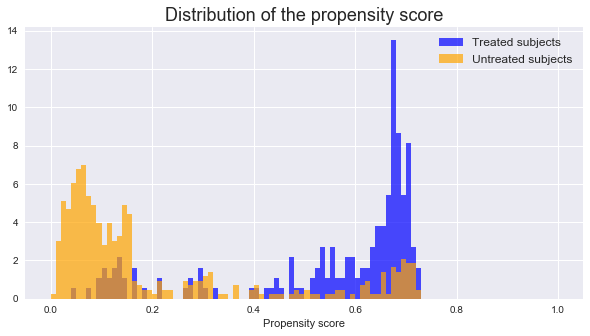

In [16]:
treated_idx = np.where(data['treat'] == 1)[0]
untreated_idx = np.where(data['treat'] == 0)[0]

prop_score_treated = prop_score[treated_idx, 1]
prop_score_untreated = prop_score[untreated_idx, 1]

# Create plots
plt.figure(figsize=(10,5))
plt.title("Distribution of the propensity score", fontsize=18)

# Plot two histograms for treated and untreated groups
plt.hist(prop_score_treated, bins=100, range=(0, 1), normed=True, color='blue', alpha=0.7)
plt.hist(prop_score_untreated, bins=100, range=(0, 1), normed=True, color='orange', alpha=0.7)
plt.xlabel('Propensity score')

# Add legend and display the plot
plt.legend(['Treated subjects', 'Untreated subjects'], loc='upper right', prop={'size': 12})
plt.show()

## 4. Balancing the dataset via matching

For this part, our goal is to find matching pairs of a treated and untreated subjects such that the absolute propensity-score differences between the two matched subjects is minimized. As hinted in the README, the `networkx` package provides a hepful function, namely `max_weight_matching(G, maxcardinality=False)`, which computes a maximum-weighted matching of the undirected graph G. From the `networkx` documentation, we learn the following: 

> A matching is a subset of edges in which no node occurs more than once. The cardinality of a matching is the number of matched edges. The weight of a matching is the sum of the weights of its edges.

Therefore, in order to solve our problem by using this function, we must create a graph that has one node for each subject and edges from every treated subject nodes to every untreated subject nodes. With this setup, a minimum matching on this graph is equivalent to selecting a set of pairs of one treated and one untreated subject. The edges of the matching thus correspond to the selected pairs.

The last thing we have to decide is how to set the weights of the edges of our graph so that the absolute propensity-score differences between matched subjects is minimized. Since the function maximizes the weight, we set the edge weights as the the negative of the absolute propensity-score differences. We still have to set the parameter `maxcardinality` to `True` so that the maximum number of edges (i.e. subject pairs) are matched.

In [18]:
# Create the graph
G = nx.graph.Graph()
    
# Create a node for each subject
for index in data.index:
    G.add_node(index)

# Create edges between each treated and untreated subjects
for t_index in treated_idx:
    for unt_index in untreated_idx:
        # Set the weight as the absolute propensity-score difference
        abs_diff = np.abs(prop_score[t_index, 1] - prop_score[unt_index, 1])
        G.add_edge(t_index, unt_index, weight=-abs_diff)

In [19]:
# Compute maximum weight matching to get pairs
matching = nx.max_weight_matching(G, maxcardinality=True)

In [20]:
# Retrieve the ids and the data of the matched subjects
matched_idx = list(matching.keys())
matched_data = data.iloc[matched_idx,:]

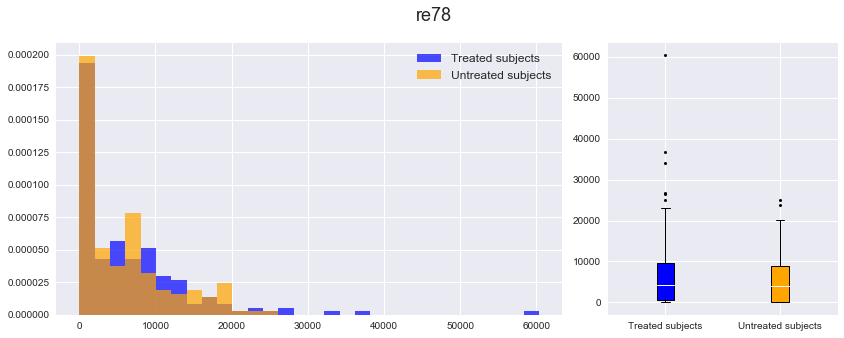

In [21]:
plot_feature_hist("re78", matched_data)

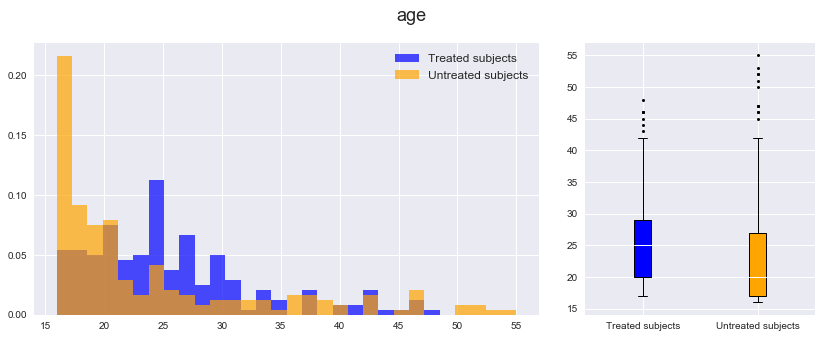

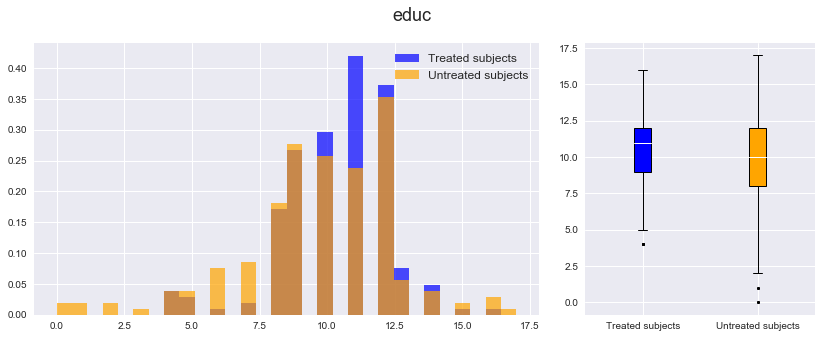

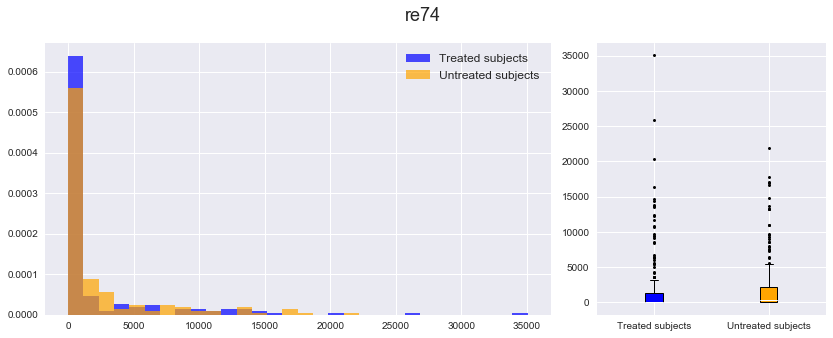

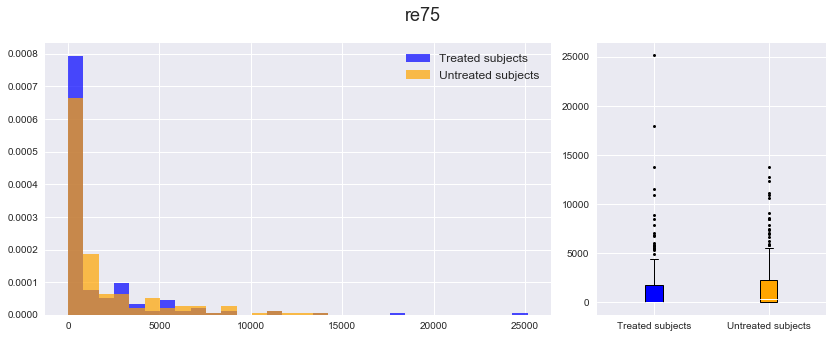

In [22]:
for col in cts_features:
    plot_feature_hist(col, matched_data)

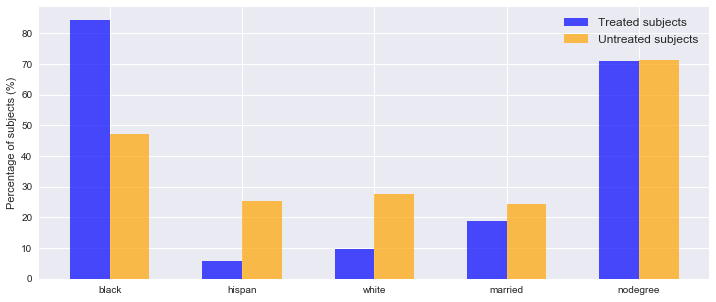

In [23]:
plot_binary_features(matched_data)

The data has a similar distribution, the treated group can now be compared with the control group.

## 5. Balancing the groups further

We notice that the black feature does not balance well enough making it diffucult to draw valid conclusion on the treatement. We will explicitly match only if this feature matches.

In [24]:
matched_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0


## 6. A less naive analysis

# Question 2: Applied ML

In [25]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
import itertools
newsgroups_train = fetch_20newsgroups(subset='train')

In [26]:
def split_data(x, y, ratio):
    '''
        split the dataset based on the split ratio. If ratio is 0.8,
        you will have 80% of your data set dedicated to training
        and the rest dedicated to testing
    '''
    random_uniform_vector = np.random.rand(x.shape[0])
    spliter = random_uniform_vector < ratio
    return (x[spliter == True], y[spliter == True]), (x[spliter == False], y[spliter == False])

In [ ]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(newsgroups_train["data"])

(train_X, train_Y), (other_X, other_Y)  = split_data(X, newsgroups_train["target"], 0.8)
(validation_X, validation_Y), (test_X, test_Y) = split_data(other_X, other_Y, 0.5)

In [ ]:
best_accuracy = 0.
best_n_est = 1
best_max_dep = 1
best_prediction = None
best_classifier = None

for n_est in range(5, 30, 5):
    for max_dep in range(20, 100, 10):
        print("doing : (%s, %s)" % (n_est, max_dep), end="\r")
        classifier = RandomForestClassifier(n_estimators=50, max_depth=100)
        classifier.fit(train_X, train_Y)
        
        prediction = classifier.predict(validation_X)
        accuracy = (len(prediction) - np.count_nonzero(prediction - validation_Y)) / len(prediction)
        
        if accuracy > best_accuracy:
            print("best accuracy : %s" % accuracy)
            best_accuracy = accuracy
            best_n_est = n_est
            best_max_dep = max_dep
            best_prediction = prediction
            best_classifier = classifier

best accuracy : 0.8094405594405595


Here we see that the importance of most feature is 0.
Then only a little fraction of the remaining importances is big (shown in the graph).

In [ ]:
non_zero_importance_count = np.count_nonzero(best_classifier.feature_importances_)
zero_importance_count = best_classifier.feature_importances_.shape[0] - non_zero_importance_count

print("non zero importance count : %s" % non_zero_importance_count)
print("zero importance count : %s" % zero_importance_count)

non_zero_indices = np.nonzero(best_classifier.feature_importances_)
plt.plot(range(non_zero_importance_count), np.sort(best_classifier.feature_importances_[non_zero_indices])[::-1])
plt.loglog()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    plt.rcParams["axes.grid"] = False
    plt.figure(figsize=(20, 20))
    
    plt.imshow(cm, cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    legend_marks = np.arange(len(classes))
    plt.xticks(legend_marks, classes, fontsize=16, rotation=90)
    plt.yticks(legend_marks, classes, fontsize=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=16)


plot_confusion_matrix(confusion_matrix(best_prediction, validation_Y), newsgroups_train.target_names)